In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:

# os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
# os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
# os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')


In [3]:
config_list = [ 'cre_setup_3_scale_1_node_info']



# config_list = ['cre_setup_2_scale_1_node_info']

# config_list2 = ['global_12cls',\
#                 'local_12cls',\
#                'global_3cls',\
#                'global_4cls',\
#                'global_6cls',\
#                'global_8cls',\
#                'global_2cls',\
#                'local_3cls',\
#                'local_4cls',\
#                'local_6cls',\
#                'local_8cls',\
#                'local_2cls']
# config_list2 = ['local_2cls']


config_list = config_list

0 0
1 0
2 0
3 0
4 1
5 1
6 1
7 1
8 1
9 -1
10 -1
11 2
12 2
13 2
14 2
15 2
16 -1
0 europe-west3-c
1 europe-west3-c
2 asia-south1-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-12].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-11].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-14].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.7   35.200.230.70  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-12  asia-south1-c  e2-highmem-2               10.160.0.23  34.100.217.29  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.32  34.93.43.198  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-11  asia-south1-c  e2-highmem-2               10.160.0.18  34.93.3.80   RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-16].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.3   34.100.204.215  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-16  asia-south1-c  e2-highmem-2               10.160.0.20  35.244.10.246  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.10  34.89.211.252  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.18  34.141.40.231  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.9   34.159.49.106  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.8   35.198.143.202  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.24  34.89.218.37  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.3   34.141.42.173  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.4   35.246.233.98  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.15  34.89.236.184  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.12  34.159.28.102  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240110'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.13  34.159.21.204  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.22  34.159.250.219  RUNNING
test:  7001 10.156.0.24
test:  7002 10.156.0.4
test:  7003 10.160.0.20


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 3s
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 2s
1 actionable task: 1 executed

----------

test:  0 10.156.0.18 10000 20000 0

test:  1 10.156.0.8 10000 20000 0

test:  2 10.156.0.22 10000 20000 0

test:  3 10.156.0.12 10000 20000 0

test:  4 10.156.0.3 10000 20000 1

test:  5 10.156.0.9 10000 20000 1

test:  6 10.156.0.10 10000 20000 1

test:  7 10.156.0.15 10000 20000 1

test:  8 10.156.0.13 10000 20000 1

test:  9 10.160.0.18 10000 20000 2

test:  10 10.160.0.23 10000 20000 2

test:  11 10.160.0.32 10000 20000 2

test:  12 10.160.0.3 10000 20000 2

test:  13 10.160.0.7 10000 20000 2

test:  7001 10.156.0.24 10000

test:  7002 10.156.0.4 10000

test:  7003 10.160.0.20 10000

test:  0 10.156.0.18 10000 20000 0

test:  1 10.156.0.8 10000 20000 0

test:  2 10.156.0.22 10000 20000 0

test:  3 10.156.0.12 10000 20000 0

test:  4 10.156.0.3 10000 20000 1

test:  5 10.156.0.9 10000 20000 1

test:  6 10.156.0.10 10000 20000 1

test:  7 10.156.0.15 10000 20000 1

test:  8 10.156.0.13 10000 20000 1

tes

ERROR: Permission to tmane002/BftSmart_Final.git denied to deploy key
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-18.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-8.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-22.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-12.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-3.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-9.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-10.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-15.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-13.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-24.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-4.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-18.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-23.us-west-1.compute.amaz

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu

Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu foca

Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:9 http://eu

Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [275 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:24 http://security.ubuntu.com/ubuntu focal-security/main Translati

Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3028 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [922 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2579 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [193 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubun

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2647 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/u

Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1145 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [275 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu

Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [489 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Pa


Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [343 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [922 kB]
Reading package lists...
Building dependency tree...Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [193 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]

Reading state information...
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [406 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2461 kB]

Reading state information...
The following packages were automatically installed and are no lo

Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (32.3 MB/s)
Fetched 48.2 MB in 2s (31.4 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to

Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libqu

Reading package lists...
Building dependency tree...Fetched 29.7 MB in 7s (4208 kB/s)
Reading package lists...Fetched 29.7 MB in 6s (5137 kB/s)
Reading package lists...Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...

Reading state information...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...


Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Reading package lists...Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
S

Fetched 29.7 MB in 6s (4994 kB/s)
Reading package lists...Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
0 upgraded, 77 newly installed, 0 to remove and 76 not upgraded.
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Need to get 80.2 MB of archives.
After this 

Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 l

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Processing triggers for man-db (2.9.1-1) ...
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Reading package lists...
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:am

Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Reading package lists...Setting up binutils (2.34-6ubuntu1.8) ...

Reading state informat

Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 li


Building dependency tree...Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]

Reading state information...
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The fol

  libc6
1 upgraded, 41 newly installed, 0 to remove and 75 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Building dependency tree...Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubun

Building dependency tree...1 upgraded, 41 newly installed, 0 to remove and 75 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binut

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to contin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
1 upgraded, 41 newly installed, 0 to remove and 75 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-com

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 libj

Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers open

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 48.2 MB in 1s (40.4 MB/s)
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc6-dev:amd64.
(Reading database ... 95%
Reading state information...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-es

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Fetched 48.2 MB in 1s (42.4 MB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libns

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
1 upgraded, 41 newly installed, 0 to remove and 75 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ub

Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:1

Selecting previously unselected package binutils.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package linux-libc-dev:amd64.
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Fetched 48.2 MB in 3s (14.0 MB/s)
Selecting previously unselected package libisl22:amd64.
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Get:16 http://asia-south1.gce.archive.ubuntu.com

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
(Reading database ... 60%
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package binutils.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package binutils.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Fetched 48.2 MB in 3s (15.9 MB/s)
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libc-dev-bin.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package gcc-9-base:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package gcc-9-base:amd64.
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libc6:amd64 (2.31-0u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package cpp-9.
(Reading database ... 62221 files and directories currently installed.)Selecting previously unselected package libctf0:amd64

Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libctf-nobfd

Selecting previously unselected package libbinutils:amd64.
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binuti

Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package

Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Setting up manpages-dev (5.05-1) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libmpc3:amd64.
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up fakeroot (1.24-1) ...
Unpacking cpp-9 (9

Selecting previously unselected package make.
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Selecting previously unselected package libdpkg-perl.
Prepari

Unpacking fakeroot (1.24-1) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package g++.
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../37

Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libquadmath0:amd64.
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Unpacking manpages-dev (5.05-1) ...
The following packages were automatically installed and are no longer required:
  lib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto modeSelecting previously unselected package manpages-dev.
Fetched 396 kB in 0s (1760 kB/s)
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...

Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...

Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up 

Unpacking g++ (4:9.3.0-1ubuntu2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Selecting previously unselected package gcc.
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package gcc.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package make.
Setting up binutils (2.34-6ubuntu1.8) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up make (4.2.1-1.2) ...
Unpacking make (4.2.1-1.2) ...Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previousl

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.9.1-1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...

Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpa

Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up make (4.2.1-1.2) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up fakeroot (1.24-1) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package fakeroot.
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...


job.sh: 12: sdk: not found


Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...

Selecting previously unselected package libfile-fcntllock-perl.
Setting up libisl22:amd64 (0.22.1-1) ...
Building dependency tree...Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking manpages-dev (5.05-1) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2

Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up fakeroot (1.24-1) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Setting up make (4.2.1-1.2) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up l

job.sh: 12: sdk: not found


Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
Setting up libc6-dev:amd6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Fetched 43.0 MB in 1s (46.3 MB/s)
Selecting previously unselected package ca-certificates-java.
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
(Reading database ... 67840 files and directories currently installed.)
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacki

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to un

Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debi

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding d

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (1052 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Reading package lists...
Building dependency tree...Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.
Need to get 40.0 kB of archives.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (1030 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5292 kB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Reading package lists

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...
Building dependency tree...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5129 kB/s)
(Reading database ... 67840 files and directories currently installed.)

Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`    

job.sh: 12: sdk: not found



Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
2 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-jav

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Reading package lists...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

Building dependency tree...Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...
Building dependency tree...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Fetched 396 kB in 0s (5023 kB/s)
(Reading database ... 95%
Reading state information...
(Reading database ... 67840 files and d

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Reading package lists...Reading package lists...
Building dependency tree...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Building dependency tree...Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (4524 kB/s)
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...

Reading state information...
Fetched 396 kB in 0s (5029 kB/s) database ... 65%
(Reading database ... 95%
Selecting previously unselected package libcups2:amd64.
Building dependency tree...Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Reading package lists...Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

Building dependency tree...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (4606 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                        

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...
Building dependency tree...Fetched 396 kB in 1s (512 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Fetched 396 kB in 1s (529 kB/s)
The following packages will be upgraded:
  curl libcurl4
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Reading state information...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack ...

job.sh: 12: sdk: not found



Reading state information...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
     

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
The following packages will be upgraded:
  curl libcurl4
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Fetched 43.0 MB in 1s (49.5 MB/s)
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh: 

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package libgraphite2-3:amd64.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`      


Reading state information...
Selecting previously unselected package libjpeg8:amd64.
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package libharfbuzz0b:amd64.
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Get:19 http://europe-west3.gce.archive.ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Fetched 43.0 MB in 1s (54.5 MB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjp

job.sh: 12: sdk: not found


Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk |

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certific

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Selecting previously unselected package libcups2:amd64.
Unpacking fonts-dejavu-core (2.37-1) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package libfontconfig1:amd64.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Selecting previously unselected package libpcsclite1:a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...Selecting previously unselected package libjpeg8:amd64.

Unpacking ca-certificates-java (20190405ubuntu1.1) ...Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.g

 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package fonts-dejavu-core.

Reading state information...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Addin

job.sh: 12: sdk: not found


Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertif

job.sh: 12: sdk: not found


Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Adding debian:Telia_Root_

job.sh: 12: sdk: not found


  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre cups-common
  liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5

Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists

job.sh: 12: sdk: not found



Reading state information...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 4s (10.5 MB/s)
Selecting previously unselected package ca-certificates-java.
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package ca-certificates-java.
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Fetched 43.0 MB in 3s (15.1 MB/s)
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking li

Adding debian:Telia_Root_CA_v2.pem
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...

Selecting previously unselected package libpcsclite1:amd64.
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Setting up fonts-dejavu-core (2.37-1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for readingUnpacking libpcsclite1:amd64 (1.8.26-3) ...
: No such file or directory
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Selecting previously unselected package fonts-dejavu-core.
Adding debian:AffirmTrust_Premium_ECC.pem
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Adding debian:Security_Communication_RootCA3.pem
Unpacking fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.

Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:COMODO_ECC_Certification_Authority.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pemSelecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
update-alternatives: using /usr/lib/jvm/jav

1 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Selecting previously unselected package default-jre-headless.
Adding debian:Certainly_Root_E1.pem
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Unpacking default-jre-hea

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ca-certificates-java.
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Fetched 40.0 kB in 0s (924 kB/s)
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:QuoVadis_Root_CA_3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /u

Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pemAdding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem

Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Selecting previously unselected package liblcms2-2:amd64.
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.

head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Selecting previously unselected package fontconfig-config.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Setting up ant-optional (1.10.7-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Adding debian:Certum_Trusted_Root_CA.pem
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:Baltimore_CyberT

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:ANF_Secure_Server_Root_CA.pemAdding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavah

Adding debian:GLOBALTRUST_2020.pemAdding debian:Amazon_Root_CA_4.pem

Adding debian:GlobalSign_Root_E46.pemAdding debian:Certigna.pem

Adding debian:GlobalSign_Root_R46.pem
Selecting previously unselected package libjpeg-turbo8:amd64.
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:Secure_Global_CA.pem
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Unpacking liblcms2-2:amd64 (2.9-4) ...
Ad

Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:UCA_Extended_Validation_Root.pem
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Selecting previously unselected package libgraphite2-3:amd64.
Adding debian:ISRG_Root_X2.pem
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
done.
Setting up ant-optional (1.10.7-1) ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Selecting previously unselected package libfontconfig1:amd64.
done.
Preparing to unpack .../13-libharfbuzz0b_2

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
done.
done.
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up iputils-ping (3:20190709-3ubuntu1) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package ant-optional.
Setting up liblcms2-2:amd64 (2.9-4) ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
(Reading database ... 68629 files and directories currently installed.)
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Prep

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS

Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
done.
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:SecureTrust_CA.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Updating certificates in /etc/ssl/certs...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:Security_Communication_RootCA3.pemThe following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/ma

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Fetched 40.0 kB in 0s (980 kB/s)
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting up iputils-ping (3:20190709-3ubuntu1) ...
Fetched 40.0 kB in 0s (951 kB/s)
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...

Reading state information...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (945 kB/s)
Selecting previously unselected package ant-optional.(Reading database ... 
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
done.ing database ... 80%
done.
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Setting up ant (1.10.7-1) ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pemThe following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-T

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem

Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Ad

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Processing triggers for man-db (2.9.1-1) ...
The following packages will be upgraded:
  i

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 40.0 kB in 0s (121 kB/s)
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (115 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 lib

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


1 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (116 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
Reading package lists...
Building dependency tree...
Reading state information...
1 upgraded, 0 newly installed, 0 to remove and 72 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]

Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
Fetched 40.0 kB in 0s (120 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
(Reading da

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (128 kB/s)
Fetched 40.0 kB in 0s (121 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..10%...................20%....10%...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.............30%..............40%................50%.................60%.......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....20%..70%.10%...............80%....10%........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....90%................100%.
.......30%.................20%..40%.....................50%.20%......................60%.................30%.....70%...............30%.........80%.....10%.............40%.............90%.....................50%...........100%.
40%....10%...................60%............50%..................70%..............20%...60%....1


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 26s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 26s
3 actionable tasks: 3 executed


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCE

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist


> Task :processResources NO-SOURCE
> Task :classes
BUILD SUCCESSFUL in 46s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 45s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 48s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 48s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main 60db440d] Working with modified ClusterInfo
 1 file changed, 16835 insertions(+)


ERROR: Permission to tmane002/BftSmart_Final.git denied to deploy key
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process fou

Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Already up to date.
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
cannot remove 'config0/currentView'

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.15.209, 10.156.15.209
-- Failed to initialize replica-to-replica communication system
java.net.BindException: Cannot assign requested address (Bind failed)
	at java.base/java.net.PlainSocketImpl.socketBind(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.bind(AbstractPlainSocketImpl.java:452)
	at java.base/java.net.ServerSocket.bind(ServerSocket.java:395)
	at java.base/java.net.ServerSocket.<init>(ServerSocket.java:257)
	at java.base/javax.net.ssl.SSLServerSocket.<init>(SSLServerSocket.java:181)
	at java.base/sun.security.ssl.SSLServerSocketImpl.<init>(SSLServerSocketImpl.java:78)
	at java.base/sun.security.ssl.SSLServerSocketFactoryImpl.createServerSocket(SSLServerSocketFactoryImpl.java:87)
	at bftsmart.communication.server.ServersCommunicationLayer.<init>(ServersC

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.72, 10.156.0.72
-- Failed to initialize replica-to-replica communication system
java.net.BindException: Cannot assign requested address (Bind failed)
	at java.base/java.net.PlainSocketImpl.socketBind(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.bind(AbstractPlainSocketImpl.java:452)
	at java.base/java.net.ServerSocket.bind(ServerSocket.java:395)
	at java.base/java.net.ServerSocket.<init>(ServerSocket.java:257)
	at java.base/javax.net.ssl.SSLServerSocket.<init>(SSLServerSocket.java:181)
	at java.base/sun.security.ssl.SSLServerSocketImpl.<init>(SSLServerSocketImpl.java:78)
	at java.base/sun.security.ssl.SSLServerSocketFactoryImpl.createServerSocket(SSLServerSocketFactoryImpl.java:87)
	at bftsmart.communication.server.ServersCommunicationLayer.<init>(ServersCommunicationLayer.java:179)
	at bftsmart.c

rm: cannot remove '*': No such file or directory
rm: cannot remove 'bft_mc_cre_setup_3_scale_1_node_info.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_3_scale_1_node_info/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_3_scale_1_node_info/nohup_client_1.out
client copying id=  16
gcloud compute scp --zone "asia-south1-c" resdb-16:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_3_scale_1_node_info/nohup_client_2.out
0
1
2
3
4
5
6
7
8
9
client copying id=  9
10
client copying id=  10
11
12
13
14
15
16
client copying id=  16
[] []


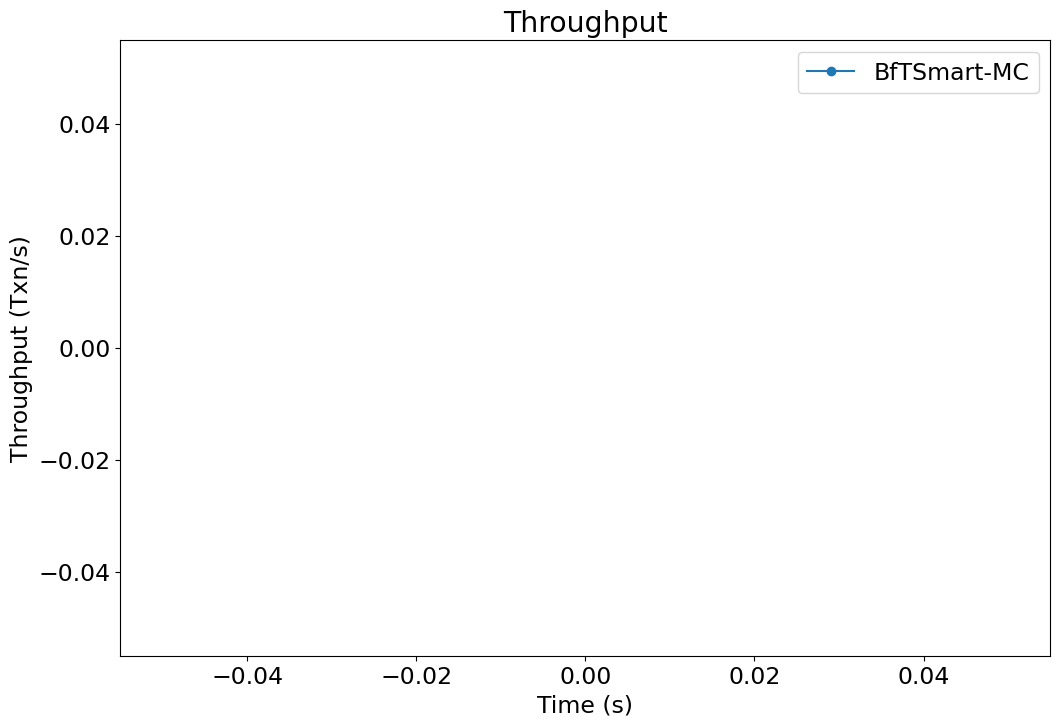

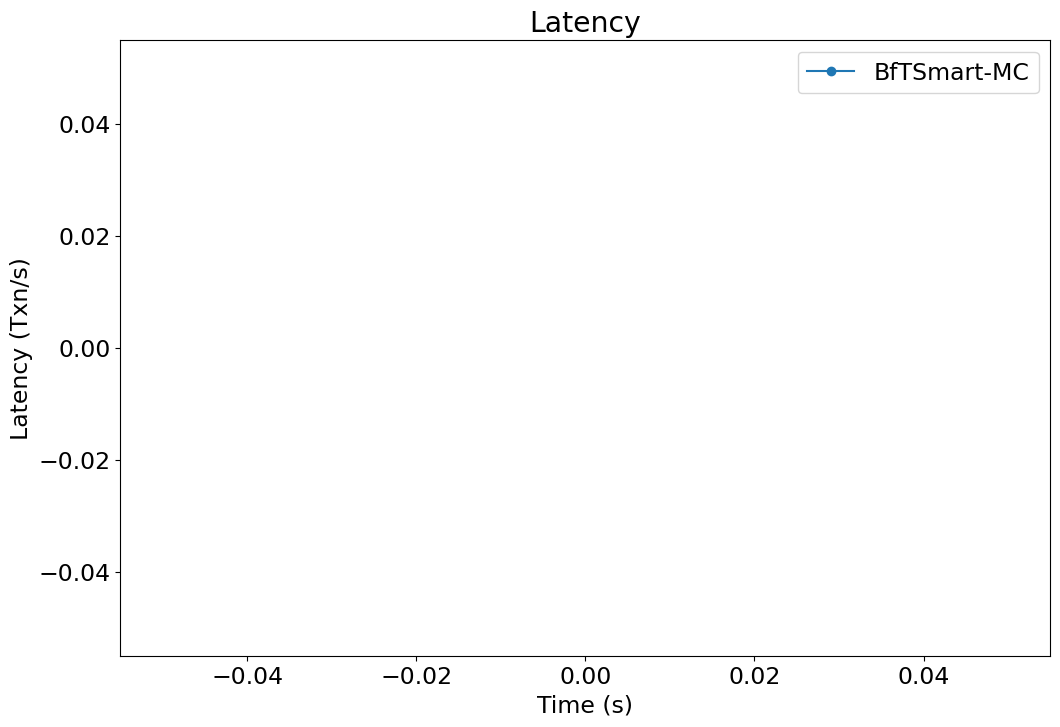

/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/pr

In [4]:

for cfig in config_list:    
    if 2>1:
        os.remove('node_info.csv')

        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count

        replica_count = 0

        for key in node_info_dict['cluster_id'].keys():
            if node_info_dict['cluster_id'][key] ==0:
                replica_count = replica_count + 1


        
        cluster_count = 0
        
        for key in node_info_dict['cluster_id']:
            print(key, node_info_dict['cluster_id'][key])
            if node_info_dict['cluster_id'][key] > cluster_count:
                cluster_count = node_info_dict['cluster_id'][key]
                
        cluster_count = cluster_count + 1
        
        n_clusters = cluster_count

        nclients = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])
            if node_info_dict['ServerOrClientregion'][i] == 1:
                nclients = nclients + 1
        nclients

        clusters_tracked = []
        cluster_regions_tracked = []

        for key in node_info_dict['region']:
            if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
                clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
                cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


        cluster_regions_tracked     

        cluster_regions_tracked, clusters_tracked


        regions = cluster_regions_tracked



        n_regions = len(regions)

        for i,k in enumerate(regions):
            print(i,k)

        for item, idx in enumerate(node_info_dict['region'].keys()):
            print(item, idx, node_info_dict['region'][item])

        lines  = []


        for idx, key in enumerate( node_info_dict['region'].keys()):

            line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
            lines.append(line)

        with open('launch_cloud_instances.sh', 'w') as f:
            for item in lines:
                f.write(str(item) + '\n')


        len(lines), node_info_dict['region'][key].strip()[1:-1]


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)

    #     time.sleep(30)

        # os.system('sh launch_cloud_instances.sh')

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
                shutil.rmtree(folder)


        instance_type = 'e2-small'


        redirect = '>'

        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')

        with open('all_internal_ips') as f:
            ipList = f.read().splitlines()
        ipList = [x for x in ipList if x!='None']

        ipList, len(ipList)

        new_server_only_ips= []
        new_client_only_ips= []



        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                new_server_only_ips = new_server_only_ips + [ipList[i]]
            else:
                new_client_only_ips = new_client_only_ips + [ipList[i]]



        # new_server_only_ips= []
        # new_client_only_ips= []


        # current_region_total = 0
        # for i in range(n_regions):
        #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
        #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

        #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
        #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


        #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

        new_server_only_ips, len(new_server_only_ips)

        new_client_only_ips, len(new_client_only_ips) 

        # ipList = new_server_only_ips + new_client_only_ips

        # ipList, len(ipList)

        nclients = 0
        nservers = 0
        count = 0

        clusterIpMap = {}


        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 0:
                clusterIpMap[nservers] = ipList[count]
                nservers = nservers + 1

            count = count + 1

        nclients = 0
        nservers = 0
        count = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 1:
                print('test: ', 7001+nclients, ipList[count])
                clusterIpMap[7001+nclients] = ipList[count]
                nclients = nclients + 1

            count = count + 1

        clusterIpMap

        # clusterIpMap = {}

        # for i in range(len(ipList)):
        #     clusterIpMap[i] = ipList[i]


        # for i in range(nclients):

        #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

        clusterPortMap1 = {}
        clusterPortMap2 = {}

        for i in range(len(ipList) - nclients):

            clusterPortMap1[i] = str(10000)

        for i in range(len(ipList) - nclients):
            clusterPortMap2[i] = str(20000)

        # clusterPortMap1[7003] = '11400'
        # clusterPortMap2[7003] = '11410'



        temp = 11900

        for i in range(nclients):

            clusterPortMap1[7001+i] = str(10000)
            clusterPortMap2[7001+i] = str(20000)

        clusterPortMap1, clusterPortMap2

        os.system('echo 3108 | sudo -S ./gradlew installDist')

        for i in range(total_count):
            os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

        os.system('echo 3108 | sudo -S ./gradlew clean')

        for key in clusterPortMap1.keys():
            if key>7002:
        #         print(key)
                print()

                for folder in os.listdir('config/'):
                    if os.path.isdir('config/'+folder) and 'keys' in folder:
                        if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                            shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                            shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

                print('----------')
                print()

        for i in range(n_clusters):

            if os.path.exists('config'+str(i)):
                shutil.rmtree('config'+str(i))

            os.mkdir('config'+str(i))
            os.mkdir('config'+str(i)+'/keysRSA')
            os.mkdir('config'+str(i)+'/keysSunEC')
            os.mkdir('config'+str(i)+'/keysECDSA')

        #     print('config'+str(i)+'/keysECDSA')


            shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
            shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
        #     print('config/workloads/', 'config'+str(i)+'/workloads')


            for file in os.listdir('config/keys/'):

                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


            shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
            shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





        clusterIpMap, clusterPortMap1

        def find_key_by_value(dictionary, value):
            for key, val in dictionary.items():
                if val == value:
                    return key
            # If the value is not found, you might want to handle this case accordingly.
            return None


        node_info_dict

        find_key_by_value(node_info_dict['ServerID'], 4)

        for n_cluster in range(n_clusters):

            with open('config'+str(n_cluster)+'/hosts.config','w') as file:

                for key in clusterIpMap:
                    if key < 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                        print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                for key in clusterIpMap:
                    if key >= 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                        print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

                file.close()


        # for n_cluster in range(n_clusters):

        #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

        #         for n_cluster1 in range(n_clusters):

        #             for i_replica in range(replica_count):
        #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
        #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

        #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
        #             print((n_clusters*replica_count) + iter_)

        # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
        #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

        #         for i in range(nclients):
        #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


        #         file.close()


        replica_count

        # for n_cluster in range(n_clusters):
        #     with open('config'+str(n_cluster)+'/system.config','r') as file:
        #         data = file.readlines()
        #         f = int(np.ceil((replica_count-1)/3))
        #         print('f is',f )

        #         for n_line in range(len(data)):
        #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


        #                 data[n_line] = 'system.servers.num = '+str(replica_count)
        #                 print(data[n_line])

        #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.servers.f = '+str(f)
        #                 print(data[n_line])


        #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.initial.view = '
        #                 for iter_view in range(replica_count):
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        #                     print(data[n_line])

        #                 data[n_line] = data[n_line][:-1]
        #                 print(data[n_line])



        #         file.close()

        #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
        #         for line in data:
        #             f.write(f"{line}\n")




        for n_cluster in range(n_clusters):
            with open('config'+str(n_cluster)+'/system.config','r') as file:
                data = file.readlines()


                nservers = 0
                server_id_list = []



                for i in node_info_dict['ServerOrClientregion']:
                    if node_info_dict['ServerOrClientregion'][i] == 0 and \
                    node_info_dict['cluster_id'][i]  == n_cluster:
                        nservers = nservers + 1
                        server_id_list.append(node_info_dict['ServerID'][i])

                f = int(np.ceil((nservers-1)/3))
                print('f is',f )


                for n_line in range(len(data)):
                    if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                        data[n_line] = 'system.servers.num = '+str(nservers)
                        print(data[n_line])

                    if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.servers.f = '+str(f)
                        print(data[n_line])


                    if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.initial.view = '
                        for iter_view in server_id_list:
                            data[n_line] = data[n_line] +str(iter_view)+','
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                            print(data[n_line])

                        data[n_line] = data[n_line][:-1]
                        print(data[n_line])



                file.close()

            with open('config'+str(n_cluster)+'/system.config', 'w') as f:
                for line in data:
                    f.write(f"{line}\n")


        for n_cluster in range(n_clusters):
            for i in range(400):

                for ncls in  range(1):


        #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

        # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')

        
        
        
        
        
        
        time.sleep(30)

        # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
        # regions = [ 'us-west1-b']


        instance_type = 'e2-small'

        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data2, len(data2)

        data = []

        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict









        # time.sleep(60)

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count





        def getTimeThps(file, flag):

            f = open(file, "r")
            data = f.readlines() 

            times = []
            thputs = []
            for line in data:
                if 'throughput[ops/s]' in line:
                    lineData = (line[13+line.find('max[ops/s])>'):-2])
                    print(lineData)

                    times.append(lineData.split('|')[0])
                    thputs.append(lineData.split('|')[-2])
            if (flag): 
                times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
                thputs.append(0)

            return np.array(times).astype(float), np.array(thputs).astype(float) 

        with open('all_external_ips') as f:
            lines = f.read().splitlines()


        lines = [x for x in lines if x!='None']
        lines, len(lines)

        for ip in lines:
            if ip!='None':
                current = (ip.split('.'))

                print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

        ## Set number of clusters

        nclusters = 0

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config':
                nclusters = nclusters + 1


        print(nclusters)





        nreplicas = int(total_count/nclusters)
        
        nclients = 0
        
        for key in node_info_dict['ServerOrClientregion']:
            if node_info_dict['ServerOrClientregion'][key]==1:
                nclients = nclients + 1
        


        nodeIps = []
        clientIps = []

        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                nodeIps.append(lines[i])
            else:
                clientIps.append(lines[i])


        # nodeIps = lines[:nclusters* nreplicas]


        # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
        no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]


        experiment = 'bft_mc_'+cfig 

        # clientIps = lines[-(nclusters):]



        # clientIps = lines[-nclients:]



        clientIps, no_cluster_yet_nodes



        node_info_dict

        node_info_dict['region'][0].strip()

        ## Functions

        def setup(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

                print(command)
                os.system(command)

        def initialize(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


                os.system(command)


        def git_clone(i):
            ip = lines[i]
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


                os.system(command)

        def git_pull(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


                os.system(command)

        def compile_job(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


                os.system(command)



        def clean_job(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm config/currentView; '
            for iter_ in range(nclusters):
                rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


                os.system(command)


        def clean_all(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


                os.system(command)





        #     if ip!='None' and( ip in no_cluster_yet_nodes):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


        #         os.system(command)        
        # #         print(command)

        def check_node(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


                os.system(command)
        #         print(command)


        def run_basic_client(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                cmd_arg = str(node_info_dict['clientID'][i])



                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


                os.system(command)


        def kill_java(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                os.system(command)



        def kill_clients(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and ip in clientIps:
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


                os.system(command)

        def run_server_node_check(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


                print(command)



        # for i in range(len(lines)):
        #     run_server_node_check(i)

        def run_basic_client_check(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                cmd_arg = str(node_info_dict['clientID'][i])


        #         print(i, cmd_arg)

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


                print(command)



        ## First Time Setup

        lines, len(lines)

        # for i in range(10):
        #     setup(i)


        results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
        print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
        print(results)  

        # ## GIT Clone/Pull



        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


        # print(results)  

        # ## Compile Job

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        print(results)  

        # ## CLEAN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        # print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


        def run_server_node(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


                os.system(command)



        # for i in node_info_dict['publicIP']:
        #     run_server_node(i)

        ## RUN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  

        ### CHECK NODE RESULT

        # check_node(0)

        # ## Run basic client

        # # time.sleep(20)
        # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
        # print(results)  

        # check_node(0)

        # time.sleep(60)

        # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

        ## Main Job

        # os.system('git add .; git commit -m "test";git push')


        # time.sleep(60)

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


        #     %%time


        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        # print(results) 





        results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


        results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  


        print('XXXXXXXX Started Servers XXXXXXXXXXXX')

        time.sleep(80)

        check_node(7)



        print('XXXXXXXX Started Clients XXXXXXXXXXXX')

        results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

        time.sleep(200)

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        check_node(0)

        if not os.path.exists('../Experiments/'+experiment):
            os.mkdir('../Experiments/'+experiment)

        os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

                break;



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 



            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)


        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            print(i)
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)


        node_info_dict

        clientIps




        def getTimesThputs(file):
            f = open(file, "r")
            data = f.readlines() 
            times = []
            thputs = []
            latencies = []
            for line in data:
        #         print(line)
                if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

        #         print(line)
                    times.append(line.split('sec:')[0].strip())
                    thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
                    read_lat = '0'
                    write_lat = '0'
                    
                    if ('READ AverageLatency' in line):
                        
                        print(line)

                        read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
                    if ('UPDATE AverageLatency' in line):                    
                        
                        write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


                    if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                        latencies.append(line.split('=')[1].split(']')[0].strip())
                    else:
                        read_frac = 0
                        write_frac = 0
                        
                        if float(read_lat) > 0:
                            read_frac = 0.85
                            
                        if float(write_lat) > 0:
                            write_frac = 0.15
                            
#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))
                        
                        lat = str( (write_frac * float(write_lat) +\
                                    read_frac*float(read_lat))/(write_frac+read_frac)\
                                 )
                        latencies.append(lat)

                    print(line,latencies[-1],thputs[-1],times[-1])

            return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


        times_thputsDict = {}
        times_latsDict = {}


        for ip in clientIps[:1]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

            print(times, thputs)
            for i in range(len(times)):
                times_thputsDict[times[i]] = thputs[i]
                times_latsDict[times[i]] = lats[i]


        for ip in clientIps[1:]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


            for i in range(len(times)):

                if times[i] in times_thputsDict.keys():
                    times_thputsDict[times[i]] += thputs[i]

                if times[i] in times_latsDict.keys():
                    times_latsDict[times[i]] += lats[i]


        times_thputsDict



        PIK = '../Experiments/'+experiment+"/pickle.dat"

        data = [times_thputsDict, times_latsDict]

        with open(PIK, "wb") as f:
            pickle.dump(data, f)

        experiment

        # experiment = 'TestRun2_8_clusters_2'
        # PIK = '../Experiments/'+experiment+"/pickle.dat"

        data2 = []
        
        with open(PIK, "rb") as f:
            data2 =  pickle.load(f)


        dict1 = data2[0]
        dict2 = data2[1]



        times1 = np.array(list(dict1.keys()))
        thputs = np.array(list(dict1.values()))

        times2 = np.array(list(dict2.keys()))
        lats = np.array(list(dict2.values()))

        times1


        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()




        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


        pl.title(r'Latency')


        pl.xlabel('Time (s)')
        pl.ylabel('Latency (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
        pl.show()

        times1, lats

        lats, np.average(lats[-85:-5])/len(clientIps)

        np.sum(thputs),  np.average(thputs[-85:-5])

        thputs

        np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

        # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

        np.sum((thputs[:180]))

        np.sum((thputs[:180]))
        
        
        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

    #             break;




        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')

#     except:
#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
#         continue
    

In [5]:
clientIps

['10.156.0.24', '10.156.0.4', '10.160.0.20']

In [6]:
np.average(lats)/nclusters

nan

In [7]:
np.average(thputs[60:80])

nan

In [8]:
n_clusters

3

gcloud compute scp --zone "europe-west3-c" commands.sh resdb-10:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-07:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-13:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-12:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-15:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-00:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-03:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-02:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-14:/home/tejas/commands.sh
gcloud compute scp --zone "europe-west3-c" commands.sh resdb-06:/home/tejas/commands.sh
gcloud compute scp --zone "asia-south1-c" commands.sh resdb-16:/home/tejas/commands.sh
gcloud compute scp --zone "europe-wes